In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from model import UNET
from utils import CarvanaDataset, dice_loss
import os
import csv

os.environ["HSA_OVERRIDE_GFX_VERSION"] = "10.3.0"
os.environ["HIP_VISIBLE_DEVICES"] = "0"
os.environ["TORCH_HOME"] = "./"

In [2]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

In [3]:
lr = 1e-4
batch_size = 16
num_epoch = 10
img_width = 240
img_height = 160
log_csv = "./train_stats.csv"
checkpoint_dir = "./checkpoints"

In [4]:
train_transforms = A.Compose(
    [
        A.Resize(height=img_height, width=img_width),
        A.Rotate(limit=30),
        A.VerticalFlip(p=0.2),
        A.HorizontalFlip(p=0.2),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        A.Resize(height=img_height, width=img_width),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255),
        ToTensorV2(),
    ]
)

train_set = CarvanaDataset(
    image_dir="../datasets/carvana/train",
    mask_dir="../datasets/carvana/train_masks",
    transforms=train_transforms,
)

val_set = CarvanaDataset(
    image_dir="../datasets/carvana/val",
    mask_dir="../datasets/carvana/val_masks",
    transforms=val_transforms,
)

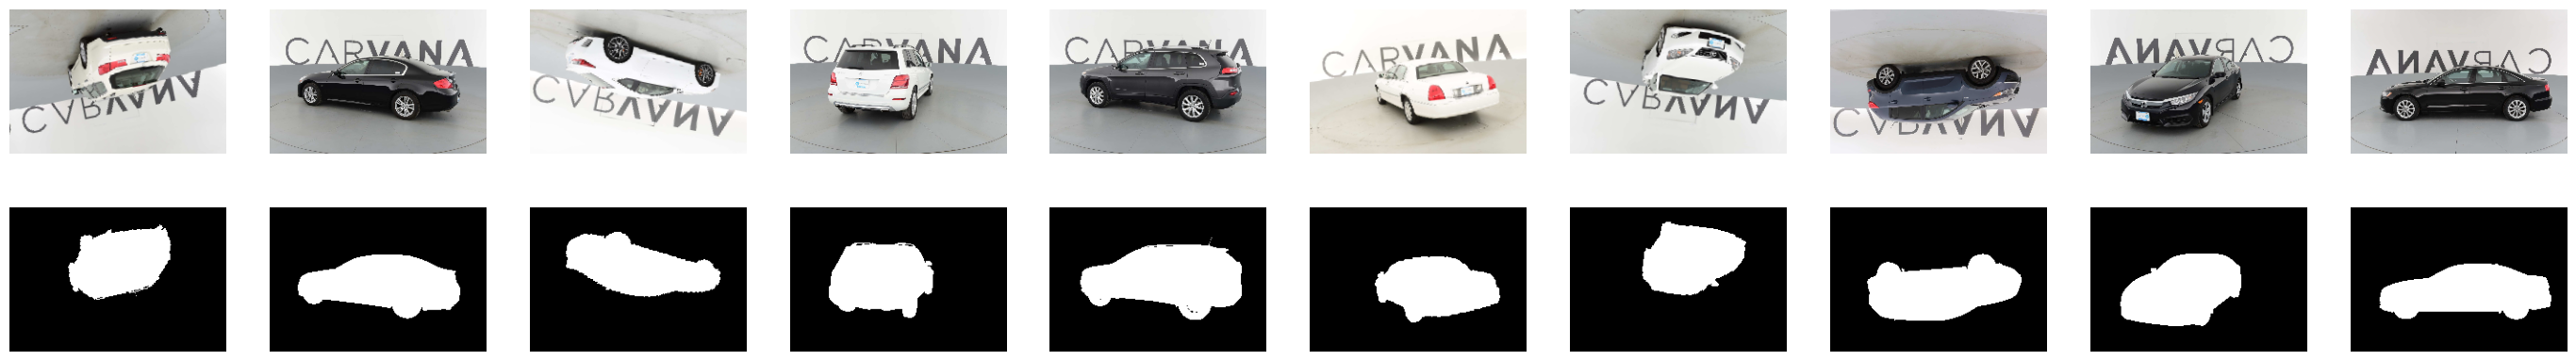

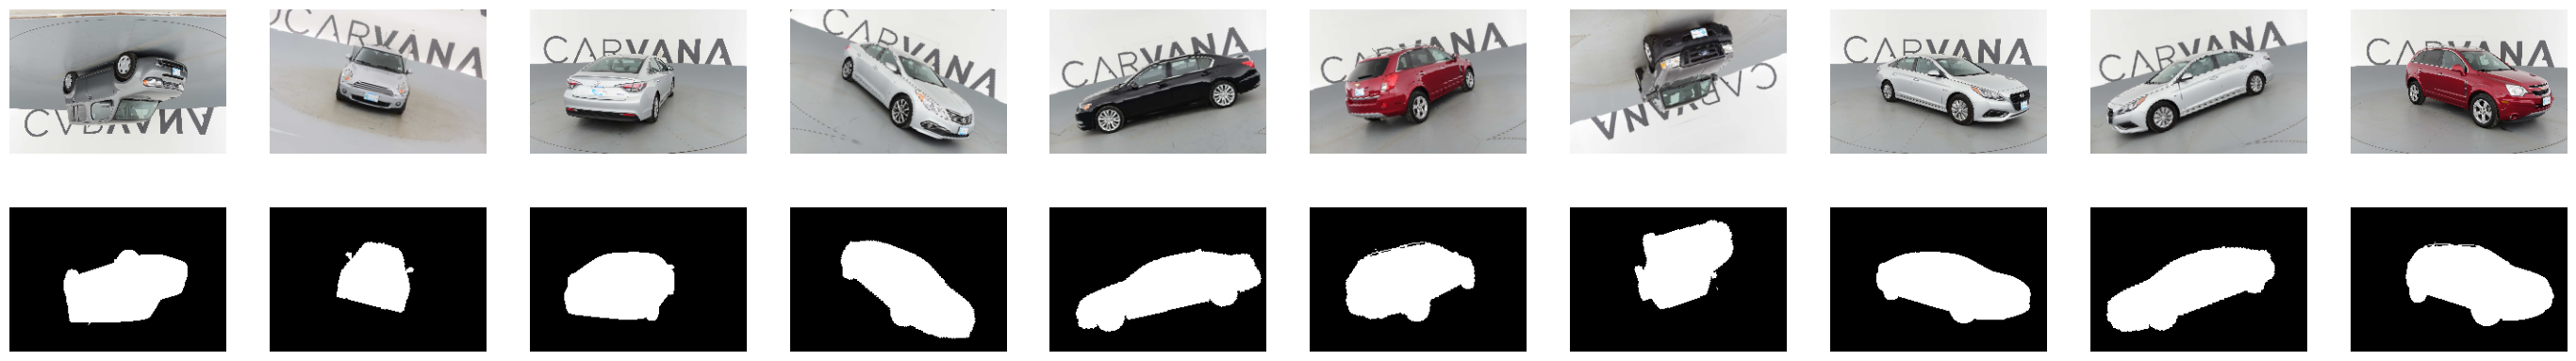

In [5]:
for data_split in [train_set, val_set]:
    idx = np.random.randint(data_split.__len__(), size=10)
    fig, axs = plt.subplots(2, 10, figsize=(35, 5))

    for ax0, ax1, i in zip(axs[0], axs[1], idx):
        img, mask = train_set[i]
        ax0.imshow(img.permute(1, 2, 0))
        ax0.axis(False)

        ax1.imshow(mask.permute(1, 2, 0), cmap="gray")
        ax1.axis(False)

    plt.show()

In [6]:
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=os.cpu_count() // 2,
    prefetch_factor=2,
)
val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=os.cpu_count() // 2,
)

In [7]:
model = UNET().to(DEVICE)

In [8]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [9]:
def train(epoch: int, loader: DataLoader, is_train=True):

    total_loss = 0.0
    itr = 0

    with torch.set_grad_enabled(is_train):

        pbar = tqdm(
            loader,
            desc=(
                f"Train epoch: {epoch + 1}" if is_train else f"Val epoch: {epoch + 1}"
            ),
        )
        for image, mask in pbar:
            image, mask = image.to(DEVICE), mask.to(DEVICE)
            out = model(image)

            loss = criterion(out, mask)

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item()
            itr += 1
            epoch_loss = total_loss / itr

            pbar.set_postfix({"Loss": f"{epoch_loss:.3f}"})

        return epoch_loss

In [10]:
with open(log_csv, "w") as f:
    fnames = ["epoch", "train_loss", "val_loss"]
    writer = csv.DictWriter(f, fieldnames=fnames)
    writer.writeheader()
os.makedirs(checkpoint_dir, exist_ok=True)

min_loss = float("inf")

for epoch in range(num_epoch):
    train_loss = train(epoch, train_loader, True)
    val_loss = train(epoch, val_loader, False)

    with open(log_csv, "a") as f:
        writer = csv.writer(f)
        writer.writerow([epoch + 1, train_loss, val_loss])

    if val_loss < min_loss:
        val_loss = min_loss
        torch.save(
            model.state_dict(), os.path.join(checkpoint_dir, "best_checkpoint.pth")
        )

torch.save(model.state_dict(), os.path.join(checkpoint_dir, "last_checkpoint.pth"))

Train epoch: 2:   0%|          | 0/302 [00:00<?, ?it/s]

Val epoch: 2:   0%|          | 0/16 [00:00<?, ?it/s]

Train epoch: 3:   0%|          | 0/302 [00:00<?, ?it/s]

Val epoch: 3:   0%|          | 0/16 [00:00<?, ?it/s]

Train epoch: 4:   0%|          | 0/302 [00:00<?, ?it/s]

Val epoch: 4:   0%|          | 0/16 [00:00<?, ?it/s]

Train epoch: 5:   0%|          | 0/302 [00:00<?, ?it/s]

Val epoch: 5:   0%|          | 0/16 [00:00<?, ?it/s]

Train epoch: 6:   0%|          | 0/302 [00:00<?, ?it/s]

Val epoch: 6:   0%|          | 0/16 [00:00<?, ?it/s]

Train epoch: 7:   0%|          | 0/302 [00:00<?, ?it/s]

Val epoch: 7:   0%|          | 0/16 [00:00<?, ?it/s]

Train epoch: 8:   0%|          | 0/302 [00:00<?, ?it/s]

Val epoch: 8:   0%|          | 0/16 [00:00<?, ?it/s]

Train epoch: 9:   0%|          | 0/302 [00:00<?, ?it/s]

Val epoch: 9:   0%|          | 0/16 [00:00<?, ?it/s]

Train epoch: 10:   0%|          | 0/302 [00:00<?, ?it/s]

Val epoch: 10:   0%|          | 0/16 [00:00<?, ?it/s]

Train epoch: 11:   0%|          | 0/302 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Mask generation


In [11]:
model.load_state_dict(
    torch.load(
        os.path.join(checkpoint_dir, "./best_checkpoint.pth"),
        weights_only=True,
        map_location=DEVICE,
    )
)

<All keys matched successfully>

In [15]:
outputs, inputs, ground_truth = [], [], []
with torch.no_grad():
    for image, mask in tqdm(val_loader):
        image, mask = image.to(DEVICE), mask.to(DEVICE)
        out = torch.sigmoid(model(image)).squeeze(0).cpu()
        outputs.extend(out)
        inputs.extend(image.cpu())
        ground_truth.extend(mask.squeeze(0).cpu())

  0%|          | 0/16 [00:00<?, ?it/s]

Dice loss: 0.021


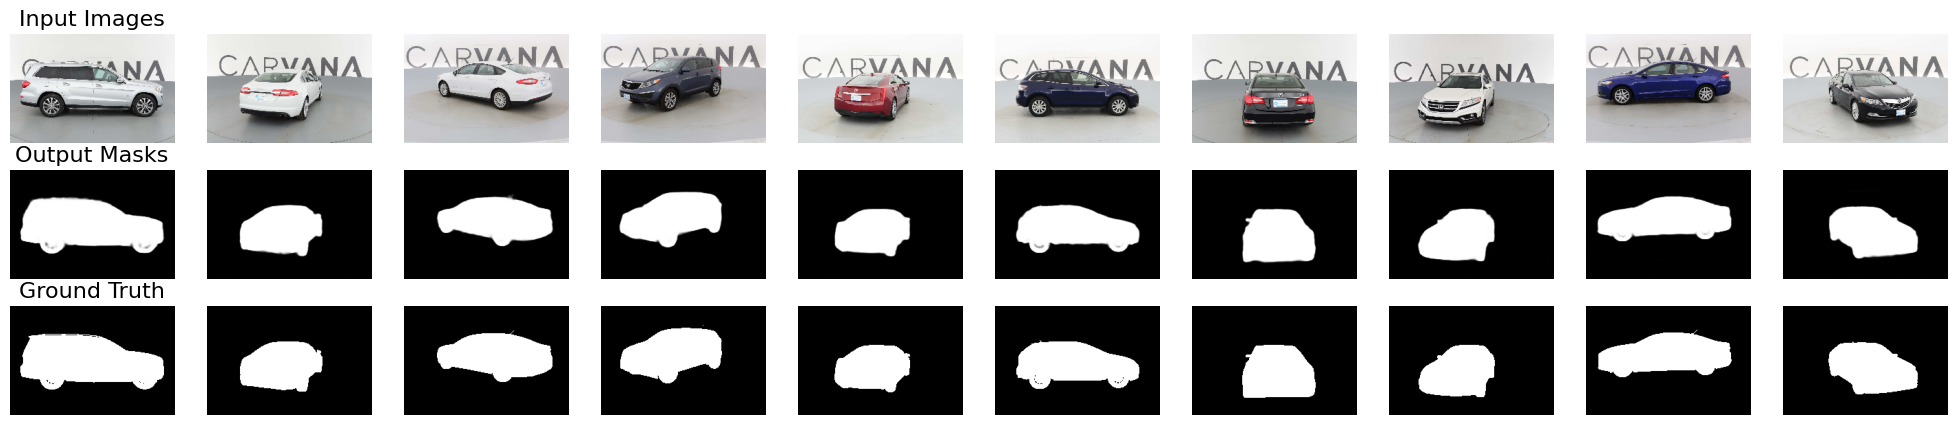

In [18]:
d_loss = dice_loss(np.array(ground_truth), np.array(outputs))
print(f"Dice loss: {d_loss:.3f}")

idxs = np.random.randint(0, len(inputs), 10)
fig, axs = plt.subplots(3, 10, figsize=(25, 5))

axs[0, 0].set_title("Input Images", loc="center", fontsize=16)
axs[1, 0].set_title("Output Masks", loc="center", fontsize=16)
axs[2, 0].set_title("Ground Truth", loc="center", fontsize=16)

for i in range(10):
    idx = idxs[i]
    axs[0, i].imshow(inputs[idx].permute(1, 2, 0))
    axs[0, i].axis(False)

    axs[1, i].imshow(outputs[idx].permute(1, 2, 0), cmap="gray")
    axs[1, i].axis(False)

    axs[2, i].imshow(ground_truth[idx].permute(1, 2, 0), cmap="gray")
    axs[2, i].axis(False)

plt.show()